In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import re
import pyodbc
from collections import OrderedDict
from itertools import product

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [127]:
def get_rfm_query(typ, count=1000):
    query = """
            select {top} c.Id CustId
                ,{field}

                from directcrm.Customers c
                    join directcrm.CustomerActions ca on c.Id = ca.CustomerId
                    join directcrm.RetailOrders ro on ca.Id = ro.FirstCustomerActionId
                    join directcrm.RetailOrderHistory roh on ro.Id = roh.OrderId
                    join directcrm.RetailPurchaseHistory rph on roh.id = rph.OrderHistoryItemId
                    join directcrm.RetailPurchaseStatuses rps on rph.StatusId = rps.Id

                where rps.CategorySystemName not in ('Returned','Cancelled','InCart') and roh.IsCurrentOtherwiseNull = 1

                group by c.Id

                order by c.Id
            """
    
    fields = {'r': 'DateDiff(hh, Max(ca.DateTimeUtc), GetDate()) Recency_hours',
              'f': 'Count(ca.Id) CountActions',
              'm': 'Sum(roh.EffectivePayedAmount) Amount'}
    
    top = ''
    if count is not None:
        top = "top({})".format(count)
    
    query = query.format(top=top, field=fields[typ])
    return query


def get_rfm_data(cnxn, typ, count=1000):
    cursor = cnxn.cursor()
    cursor.execute(get_rfm_query(typ, count))
    rows = list(map(lambda t: [t[0], t[1]], cursor.fetchall()))
    df = pd.DataFrame(rows, columns=['id', 'rfm_{}'.format(typ)])
    return df


def get_full_rfm_data(count = 100): 
    cnxn = pyodbc.connect(driver='{SQL Server}',
                          server='aurora',
                          database='hoff')
    data_r = get_rfm_data(cnxn, 'r', count=count)
    data_f = get_rfm_data(cnxn, 'f', count=count)
    data_m = get_rfm_data(cnxn, 'm', count=count)
    cnxn.close()
    
    if sum (data_r.id != data_f.id) or sum(data_r.id != data_m.id):
        raise RuntimeError("Не совпадают индексы")
    else:
        data = pd.concat([data_r, data_f.drop('id', axis=1), data_m.drop('id', axis=1)], axis=1)
    data['rfm_m'] = data['rfm_m'].astype(float)
    return data


def reduce_tails(data, min_q=0.025, max_q=0.975):
    filtered_data = data[(data['rfm_r'] >= data['rfm_r'].quantile(min_q)) &
                         (data['rfm_r'] <= data['rfm_r'].quantile(max_q)) &
                         (data['rfm_f'] >= data['rfm_f'].quantile(min_q)) &
                         (data['rfm_f'] <= data['rfm_f'].quantile(max_q)) &
                         (data['rfm_m'] >= data['rfm_m'].quantile(min_q)) &
                         (data['rfm_m'] <= data['rfm_m'].quantile(max_q))]
    return filtered_data


def draw_3d_plot(data, labels=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    
    if labels is None:
        x = list(data['rfm_r'])
        y = list(data['rfm_f'])
        z = list(data['rfm_m'])
        ax.scatter(x, y, z)
        
    else:
        for n in np.unique(labels):
            indices = labels == n
            x = list(data.loc[indices, 'rfm_r'])
            y = list(data.loc[indices, 'rfm_f'])
            z = list(data.loc[indices, 'rfm_m'])

            c = [[n * 2 % 256, n * 5 % 256, n * 13 % 256]]
            ax.scatter(x, y, z)

In [8]:
raw_data = get_full_rfm_data(10000)
reduced_data = reduce_tails(raw_data.copy(), 0.01, 0.99)

# Алгоритмы

## Выбор подходящих алгоритмов и метрик

### Алгоритмы с заданным числом кластеров

**<font color=#009933>K-means</font>** - классика, без него никуда.
Не слишком быстрый, зато простой и понятный.
Можно задать число кластеров.

**<font color=#009933>Spectral clustering</font>** - объединенный подход. Хорошо подходит для небольшого числа кластеров. Не очень хорош для большого числа данных.
*<font color=orange>Медленный</font>*.

**<font color=#009933>Agglomerative clustering</font>** - самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров.

**<font color=#993333>Birch</font>** - вроде неплохо. Сначала кластеризует, автоматически выбирая число кластеров, затем урезает при помощи AgglomerativeСlustering. *Вообще не может разделить объекты*

### Алгоритмы без заданного числа кластеров

**<font color=#993333>Affinity Propagation</font>** - ищет похожие объекты.
Плохо, что нельзя задать число кластеров.
Еще проблема: выбор метрики. 
*Ооооочень медленный.*
*Выдает Ооооочень много кластеров*

**<font color=#009933>Mean-shift</font>** - То же, но другая мера растояния

**<font color=#993333>DBSCAN</font>** - подходит для большого числа данных и среднего числа кластеров.
*Выдает мало кластеров*


**<font color=#993333>Gaussian mixtures</font>** - вроде неплохо. *Но это из другой оперы*

### Метрики, не требующие знания истинных меток классов
*Пока рассматриваем только их*

**Silhouette Coefficient** - силуэт. От -1 до +1.

**Calinski-Harabaz Index** - быстро считается

In [27]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score

In [13]:
data = reduced_data
X = data[['rfm_r', 'rfm_f', 'rfm_m']]
X_scaled_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_scaled_mm = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

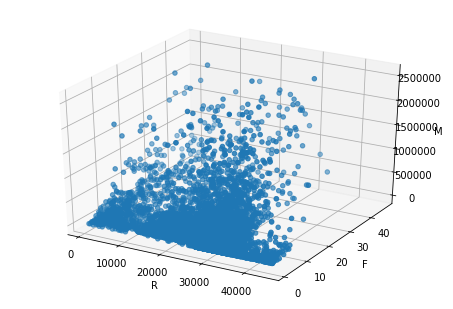

In [133]:
draw_3d_plot(X)

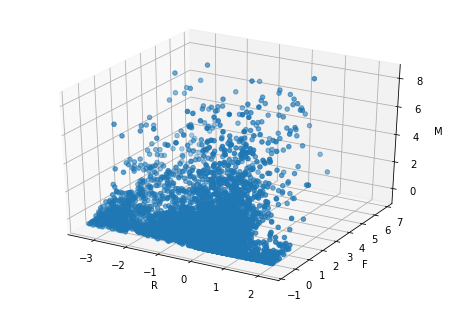

In [132]:
draw_3d_plot(X_scaled_std)

In [105]:
def tuning(X, params, clr, rs=None, print_lbs_num=False):
    #import ipdb; ipdb.set_trace()
    names = list(params.keys())
    values_lists = list(params.values())
    combs = list(product(*values_lists))
    
    m1, m2 = [], []
    for comb in combs:
        kwargs = {name: comb[i] for i, name in enumerate(names)}
        labels = clr(**kwargs).fit(X).labels_
        lbs_num = len(np.unique(labels))
        if lbs_num > 1:
            m1.append(silhouette_score(X, labels, random_state=rs))
            m2.append(calinski_harabaz_score(X, labels))
        else:
            m1.append(-1)
            m2.append(-1)
        if print_lbs_num:
            print(comb, lbs_num)
    return combs, m1, m2

In [47]:
def choose_best(combs, m1, m2):
    best_1, best_2 = np.argmax(m1), np.argmax(m2)
    best_comb_1, best_comb_2 = combs[best_1], combs[best_2]
    best_res_1, best_res_2 = m1[best_1], m2[best_2]
    return {'m1': (best_comb_1, best_res_1), 'm2': (best_comb_2, best_res_2)}

In [103]:
from sklearn.cluster import (KMeans, SpectralClustering, 
                             AffinityPropagation, MeanShift,
                             AgglomerativeClustering, DBSCAN,
                             Birch)


In [48]:
rs=17

In [97]:
# Kmeans
params_kmeans = {'n_clusters': list(range(8, 14 + 1)),
                 'random_state': [rs],
                 'n_jobs': [-3]}

combs_kmeans, m1_kmeans, m2_kmeans = tuning(X, params_kmeans, KMeans, rs=rs)
combs_kmeans, m1_kmeans_mm, m2_kmeans_mm = tuning(X_scaled_mm, params_kmeans, KMeans, rs=rs)

In [112]:
list(zip(combs_kmeans, m1_kmeans, m2_kmeans))

[((8, 17, -3), 0.6460641992553021, 65168.37436669474),
 ((9, 17, -3), 0.616574240335514, 71437.12915398303),
 ((10, 17, -3), 0.5833808586618573, 77322.32147651933),
 ((11, 17, -3), 0.5849259341875026, 81533.5441936499),
 ((12, 17, -3), 0.5562882286183207, 87156.47342777335),
 ((13, 17, -3), 0.5530080913097856, 94005.33384006463),
 ((14, 17, -3), 0.552324932098759, 99065.34667460693)]

In [113]:
list(zip(combs_kmeans, m1_kmeans_mm, m2_kmeans_mm))

[((8, 17, -3), 0.3825599672852, 6411.670390374174),
 ((9, 17, -3), 0.390511220767914, 6335.927382021979),
 ((10, 17, -3), 0.386950117820281, 6319.802154652567),
 ((11, 17, -3), 0.38922780891223113, 6169.709537650278),
 ((12, 17, -3), 0.38372122676577036, 6064.13926236224),
 ((13, 17, -3), 0.38383978031979327, 5980.131821545159),
 ((14, 17, -3), 0.38201194827368934, 5954.569105204152)]

In [98]:
# Spectral clustering
params_spectral = {'n_clusters': list(range(8, 14 + 1)),
                   'affinity': ['rbf', 'nearest_neighbors'],
                   'n_neighbors': [10, 50, 100],
                   'n_jobs': [-3],
                   'eigen_solver': ['arpack'],
                   'random_state': [rs]}

combs_spectral, m1_spectral, m2_spectral = tuning(X, params_spectral, SpectralClustering, rs=rs)
combs_spectral, m1_spectral_mm, m2_spectral_mm = tuning(X_scaled_mm, params_spectral, SpectralClustering, rs=rs)

C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [120]:
#list(zip(combs_spectral, m1_spectral, m2_spectral))

In [142]:
list(zip(combs_spectral, m1_spectral_mm, m2_spectral_mm))

[((8, 'rbf', 10, -3, 'arpack', 17), 0.3253483706139502, 4386.690413069361),
 ((8, 'rbf', 50, -3, 'arpack', 17), 0.3253483706139502, 4386.690413069361),
 ((8, 'rbf', 100, -3, 'arpack', 17), 0.3253483706139502, 4386.690413069361),
 ((8, 'nearest_neighbors', 10, -3, 'arpack', 17),
  -0.039640994591135896,
  817.8241055051657),
 ((8, 'nearest_neighbors', 50, -3, 'arpack', 17),
  -0.02136243719266998,
  1357.265069041171),
 ((8, 'nearest_neighbors', 100, -3, 'arpack', 17),
  -0.005227991230828221,
  1511.424660452973),
 ((9, 'rbf', 10, -3, 'arpack', 17), 0.3247720169407053, 4158.996861806354),
 ((9, 'rbf', 50, -3, 'arpack', 17), 0.3247720169407053, 4158.996861806354),
 ((9, 'rbf', 100, -3, 'arpack', 17), 0.3247720169407053, 4158.996861806354),
 ((9, 'nearest_neighbors', 10, -3, 'arpack', 17),
  0.003734488002779661,
  1204.3979898021582),
 ((9, 'nearest_neighbors', 50, -3, 'arpack', 17),
  0.005315571020008039,
  1377.8284006054141),
 ((9, 'nearest_neighbors', 100, -3, 'arpack', 17),
  -0.0

In [122]:
choose_best(combs_spectral, m1_spectral, m2_spectral)

{'m1': ((8, 'nearest_neighbors', 50, -3, 'arpack', 17), 0.42765166435206936),
 'm2': ((10, 'nearest_neighbors', 10, -3, 'arpack', 17), 42109.632641523414)}

In [123]:
choose_best(combs_spectral, m1_spectral_mm, m2_spectral_mm)

{'m1': ((12, 'rbf', 10, -3, 'arpack', 17), 0.3551100893816821),
 'm2': ((12, 'rbf', 10, -3, 'arpack', 17), 4672.0018103299235)}

In [125]:
params_spectral_best = {'n_clusters': 9,
                        'affinity': 'nearest_neighbors',
                        'n_neighbors': 30,
                        'n_jobs': -3,
                        'eigen_solver': 'arpack',
                        'random_state': rs}
model_spectral = SpectralClustering(**params_spectral_best).fit(X)

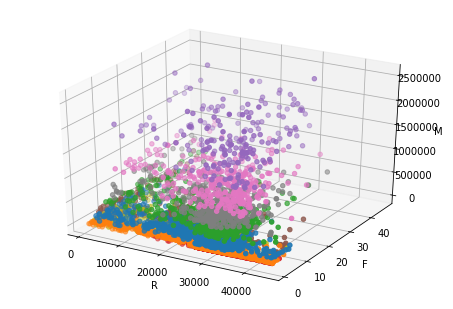

In [128]:
draw_3d_plot(X, model_spectral.labels_)

In [130]:
params_spectral_best_mm = {'n_clusters': 12,
                        'affinity': 'rbf',
                        'n_neighbors': 10,
                        'n_jobs': -3,
                        'eigen_solver': 'arpack',
                        'random_state': rs}
model_spectral_mm = SpectralClustering(**params_spectral_best_mm).fit(X_scaled_mm)

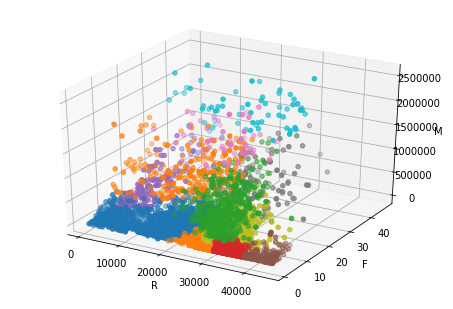

In [131]:
draw_3d_plot(X, model_spectral_mm.labels_)

In [99]:
# Agglomerative Clustering
params_agglmrt = {'n_clusters': list(range(8, 14 + 1)),
                  'affinity': ['euclidean'],
                  'linkage': ['ward', 'complete', 'average']}

combs_agglmrt, m1_agglmrt, m2_agglmrt = tuning(X, params_agglmrt, AgglomerativeClustering, rs=rs)
combs_agglmrt, m1_agglmrt_mm, m2_agglmrt_mm = tuning(X_scaled_mm, params_agglmrt, AgglomerativeClustering, rs=rs)

In [136]:
list(zip(combs_agglmrt, m1_agglmrt, m2_agglmrt))

[((8, 'euclidean', 'ward'), 0.6166191468026829, 60567.57801353911),
 ((8, 'euclidean', 'complete'), 0.7654297287718175, 17930.268714501373),
 ((8, 'euclidean', 'average'), 0.7669987529901978, 21565.085900633592),
 ((9, 'euclidean', 'ward'), 0.5776526336818962, 61074.72823760475),
 ((9, 'euclidean', 'complete'), 0.7624409286936726, 16832.568065145646),
 ((9, 'euclidean', 'average'), 0.7163646687844923, 25777.409205489705),
 ((10, 'euclidean', 'ward'), 0.5773151670722128, 63214.09734089688),
 ((10, 'euclidean', 'complete'), 0.762149531702841, 15166.92821402839),
 ((10, 'euclidean', 'average'), 0.7178486947142289, 23598.735629276798),
 ((11, 'euclidean', 'ward'), 0.5780152797628914, 67157.211246921),
 ((11, 'euclidean', 'complete'), 0.6972366398509817, 36873.27373755076),
 ((11, 'euclidean', 'average'), 0.7177118916471459, 21289.798481400063),
 ((12, 'euclidean', 'ward'), 0.5762722381248427, 71838.67337027451),
 ((12, 'euclidean', 'complete'), 0.6927910831038823, 40926.293622366196),
 ((1

In [137]:
list(zip(combs_agglmrt, m1_agglmrt_mm, m2_agglmrt_mm))

[((8, 'euclidean', 'ward'), 0.337785879179299, 5260.71358154326),
 ((8, 'euclidean', 'complete'), 0.5767141254747947, 2534.5768412243774),
 ((8, 'euclidean', 'average'), 0.6123565949491121, 2000.9321630026586),
 ((9, 'euclidean', 'ward'), 0.34412882232060693, 5377.879991026016),
 ((9, 'euclidean', 'complete'), 0.5477407622091486, 2722.4207938217555),
 ((9, 'euclidean', 'average'), 0.6126289165123561, 1779.0709256618306),
 ((10, 'euclidean', 'ward'), 0.35691453208810436, 5405.149305401356),
 ((10, 'euclidean', 'complete'), 0.5472480301118166, 2442.114539750571),
 ((10, 'euclidean', 'average'), 0.6077154749285895, 1584.13573807687),
 ((11, 'euclidean', 'ward'), 0.35744951372088085, 5246.163373819493),
 ((11, 'euclidean', 'complete'), 0.42828716698376995, 2542.154671973188),
 ((11, 'euclidean', 'average'), 0.6074323218528338, 1432.377989596212),
 ((12, 'euclidean', 'ward'), 0.3591500401798519, 5148.589898559693),
 ((12, 'euclidean', 'complete'), 0.4271966866974733, 2352.526545016828),
 ((

In [138]:
bests = choose_best(combs_agglmrt, m1_agglmrt_mm, m2_agglmrt_mm)

In [141]:
bests['m1'][0]

(9, 'euclidean', 'average')

In [108]:
# Mean-shift
params_meanshift = {'cluster_all': [True, False],
                    'n_jobs': [-3] }
combs_meanshift, m1_meanshift, m2_meanshift = tuning(X, params_meanshift, MeanShift, rs=rs, print_lbs_num=True)
combs_meanshift, m1_meanshift_mm, m2_meanshift_mm = tuning(X_scaled_mm, params_meanshift, MeanShift, rs=rs, print_lbs_num=True)

(True, -3) 9
(False, -3) 10
(True, -3) 17
(False, -3) 18


In [118]:
list(zip(combs_meanshift, m1_meanshift, m2_meanshift))

[((True, -3), 0.8039423717512586, 10321.427307718664),
 ((False, -3), 0.7156019760410074, 5608.626395440727)]

In [119]:
list(zip(combs_meanshift, m1_meanshift_mm, m2_meanshift_mm))

[((True, -3), 0.6102100040067456, 1378.033484333942),
 ((False, -3), 0.4953979341947823, 551.0453582323472)]

In [32]:
def tune_kmeans1(X, n_cl_min=8, n_cl_max=12, rs=None, plot=False):
    m1, m2 = OrderedDict(), OrderedDict()
    inertias = OrderedDict()
    for n in range(n_cl_min, n_cl_max + 1):
        model = KMeans(n_clusters=n, random_state=rs).fit(X)
        m1[n] = silhouette_score(X, model.labels_, random_state=rs)
        m2[n] = calinski_harabaz_score(X, model.labels_)
        inertias[n] = model.inertia_
    if plot:
        plt.plot(inertias.keys(), inertias.values())
    return m1, m2

In [83]:
# Affinity Propagation
params_affprop = { 'affinity': ['euclidean'],
                   'damping': [0.5, 0.65, 0.8, 0.95]}

combs_affprop, m1_affprop, m2_affprop = tuning(X, params_affprop, AffinityPropagation, rs=rs)

C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:205: RuntimeWarning: invalid value encountered in true_divide
  sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)


('euclidean', 0.5) [   0    1    2 ... 5299 5300 5301]


KeyboardInterrupt: 

In [ ]:
# Gaussian Mixture
params_gaussmix = {'n_components': [1, 5, 10],
                   'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                   'n_init': [5],
                   'random_state': [rs]}

combs_gaussmix, m1_gaussmix, m2_gaussmix = tuning(X, params_gaussmix, GaussianMixture, rs=rs, print_lbs_num=True)
combs_gaussmix, m1_gaussmix_mm, m2_gaussmix_mm = tuning(X_scaled_mm, params_gaussmix, GaussianMixture, rs=rs, print_lbs_num=True)

In [107]:
# Birch
params_birch = {'n_clusters': list(range(8, 14 + 1))}

combs_birch, m1_birch, m2_birch = tuning(X, params_birch, Birch, rs=rs)
combs_birch, m1_birch_mm, m2_birch_mm = tuning(X_scaled_mm, params_birch, Birch, rs=rs)

C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (8). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (9). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (10). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\birch.py:629: UserWarning: Number of subclusters found (1) by Birch is less than (11). Decrease the threshold.
  % (len(centroids), self.n_clusters))
C:\Users\feldman\AppData\Local\Continuum\anaconda3\lib\site-pa

In [109]:
# DBSCAN
params_dbscan = {'metric': ['euclidean'],
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'n_jobs': [-3]}

combs_dbscan, m1_dbscan, m2_dbscan = tuning(X, params_dbscan, DBSCAN, rs=rs, print_lbs_num=True)
combs_dbscan, m1_dbscan_mm, m2_dbscan_mm = tuning(X_scaled_mm, params_dbscan, DBSCAN, rs=rs, print_lbs_num=True)

('euclidean', 'auto', -3) 2
('euclidean', 'ball_tree', -3) 2
('euclidean', 'kd_tree', -3) 2
('euclidean', 'brute', -3) 2
('euclidean', 'auto', -3) 1
('euclidean', 'ball_tree', -3) 1
('euclidean', 'kd_tree', -3) 1
('euclidean', 'brute', -3) 1


In [145]:
MeanShift??